In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from ripser import ripser, Rips
import stablerank.srank as sr
import numpy as np
from tqdm import tqdm



In [2]:
df_read = pd.read_csv('data/braincancer.csv')

In [3]:
#Remove sample index column
df = df_read.copy().drop(columns = ['samples'])

In [4]:
#Create dictionary with sample sizes for each type
types = set(df['type'])
sample_size = {}

for t in types:
    sample_size[t] = len(df['type'].loc[df['type'] == t])

min_sample_size = min(sample_size.values())
total_size = len(df)

In [5]:
#Split data into train data and test data
pct_test = 0.2 #MINIMUM percentage of test data FOR EACH TYPE
train_data_amount = int(min_sample_size*(1-pct_test))

df = df.sample(frac=1) #Shuffle data frame rows

train_data_condition = df[['type']].copy()
train_data_condition['train'] = [False]*total_size
counter = {t: 0 for t in types}
for i in range(total_size):
    current_type = train_data_condition.at[i,'type']
    if counter[current_type] < train_data_amount:
        train_data_condition.at[i,'train'] = True
        counter[current_type] += 1

df_train = df.loc[train_data_condition['train']]
df_test = df.loc[~train_data_condition['train']]
    

In [6]:
#Create dictionary with sample sizes for each type in train and test data (mainly a check)

sample_size_train = {}
sample_size_test = {}

for t in types:
    sample_size_train[t] = len(df_train['type'].loc[df_train['type'] == t])
    sample_size_test[t] = len(df_test['type'].loc[df_test['type'] == t])

print("Train:", sample_size_train)
print("Test:", sample_size_test)

Train: {'pilocytic_astrocytoma': 10, 'ependymoma': 10, 'glioblastoma': 10, 'medulloblastoma': 10, 'normal': 10}
Test: {'pilocytic_astrocytoma': 5, 'ependymoma': 36, 'glioblastoma': 24, 'medulloblastoma': 12, 'normal': 3}


In [7]:
#Identify relevant features and normalize
N_features = 1100

df = df_train
labels = df['type'].to_numpy()
X = df.drop(columns = ['type'])
y = df['type']

#normalization_coefficients = X.mean()
##Normalize data
#X = X/normalization_coefficients

#test_labels = df_test['type'].to_numpy()
#df_test = df_test.drop(columns = ['type'])/normalization_coefficients
#df_test['type'] = test_labels

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=N_features)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns


df_train = df_train[list(featureScores.nlargest(N_features,'Score')['Specs']) +['type']].copy()
df_test = df_test[list(featureScores.nlargest(N_features,'Score')['Specs']) +['type']].copy()

In [8]:
df_test.shape

(80, 1101)

In [9]:
def replace_one_row(df,new_row):
    """Returns a list of all dataframes which can be formed by replacing one row of df with new_row"""
    new_data_frames = []
    for i in range(len(df)):
        df_new = df.copy()
        df_new.iloc[i,:] = new_row.copy().iloc[0,:]
        new_data_frames.append(df_new)
    return new_data_frames

In [10]:
def analyze_space(X,dist_type = 'euclidean', max_dim = 1, max_size = 1000):
    """Return topological data for given data frame"""
    #Transpose data
    X = np.array(X)[:,:max_size]
    X = np.transpose(X)
    
    dist = squareform(pdist(X, dist_type))

    # getting a distance object
    c_dist = sr.Distance(dist)

    # getting h0sr
    pcf = c_dist.get_h0sr(clustering_method = "complete", reduced = False)

    #getting bar codes
    bc = c_dist.get_bc(maxdim=max_dim)
    
    data = {"bar code": bc, "H0": pcf}
    #getting Hi for i>0
    for i in range(1,max_dim+1):
        
        data['H'+str(i)] = sr.bc_to_sr(bc, degree="H"+str(i))
    return data
    

In [11]:
#Produce bar codes for train data spaces
train_data = {}
md = 1 #max dimension
dist_type = 'euclidean' #Type of distance
max_size = 2000

for cancer_type in tqdm(types):
    df = df_train.loc[df_train['type'] == cancer_type]
    X = df.drop(columns=['type'])
    
    data = analyze_space(X,dist_type = dist_type, max_dim = md,max_size = max_size)
    
    train_data[cancer_type] = data

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


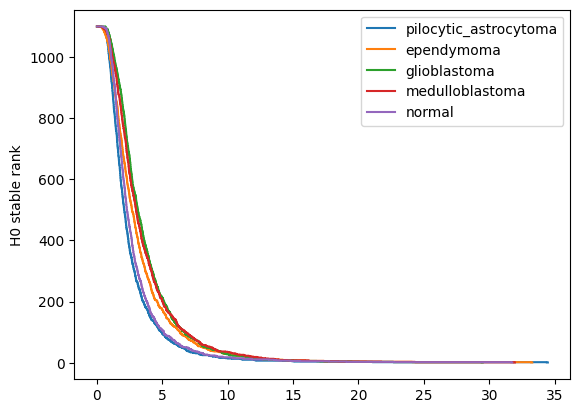

In [12]:
plt.figure()
for cancer_type in types:
    train_data[cancer_type]["H0"].plot(label =cancer_type)

plt.ylabel("H0 stable rank")
plt.legend()
plt.show()

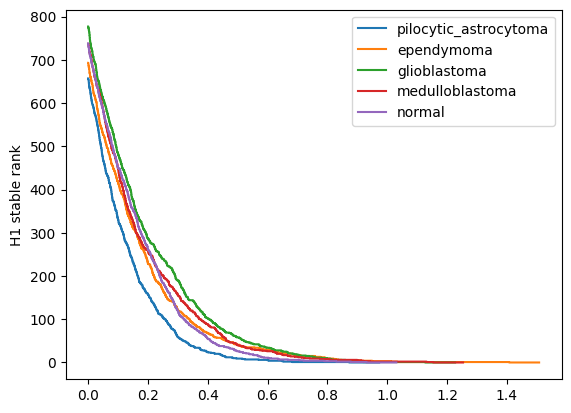

In [13]:
plt.figure()
for cancer_type in types:
    train_data[cancer_type]["H1"].plot(label =cancer_type)

plt.ylabel("H1 stable rank")
plt.legend()
plt.show()

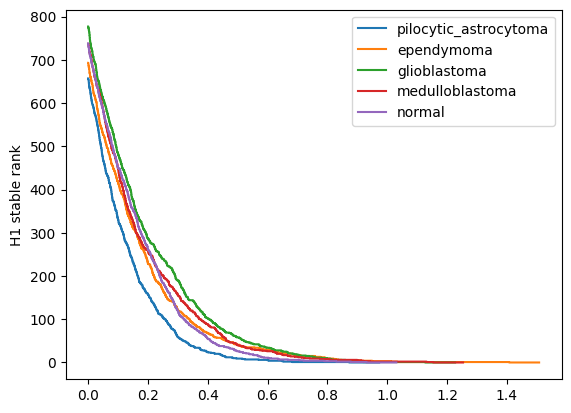

In [14]:
plt.figure()
for cancer_type in types:
    train_data[cancer_type]["H1"].plot(label =cancer_type)

plt.ylabel("H1 stable rank")
plt.legend()
plt.show()

In [15]:
def new_row_evaluation(X,new_row, dist_type = 'euclidean', max_dim = 1,max_size = 1000):
    """Calculate change in persistent homology and distance between pcf:s when a new data point is inserted 
    instead of an old row"""
    train_data = analyze_space(X,dist_type, max_dim, max_size)#To be compared with new data
    
    new_data_frames = replace_one_row(X,new_row)
    all_data = []
    for Y in new_data_frames:
        all_data.append(analyze_space(Y,dist_type, max_dim, max_size))
    
    #Calculate average persistent homology
    avg_hom = {}
    for i in range(0,max_dim+1):
        for j, data in enumerate(all_data):
            if j == 0:
                f = data['H'+str(i)]
            else:
                f = f+data['H'+str(i)]
        avg_hom['H'+str(i)] = f/len(all_data)
    
    #Calculate average distance between new and old space for each homology
    avg_dist = {}
    for i in range(0,max_dim+1):
        H_train_data = train_data['H'+str(i)]
        d = 0
        for data in all_data:
            d += H_train_data.interleaving_distance(data['H'+str(i)])
        avg_dist['H'+str(i)] = d/len(all_data)
    
    return avg_hom, avg_dist

True type: ['basal']
luminal_B {'H0': 2.4886115406656617, 'H1': 0.09755580425262451}
basal {'H0': 1.9580610212923797, 'H1': 0.21597683429718018}
luminal_A {'H0': 1.983476323503884, 'H1': 0.15163848400115967}
normal {'H0': 2.4417851125639958, 'H1': 0.2195124387741089}
cell_line {'H0': 1.4629206934090093, 'H1': 0.2202895164489746}
HER {'H0': 1.6501605837926505, 'H1': 0.2302717685699463}


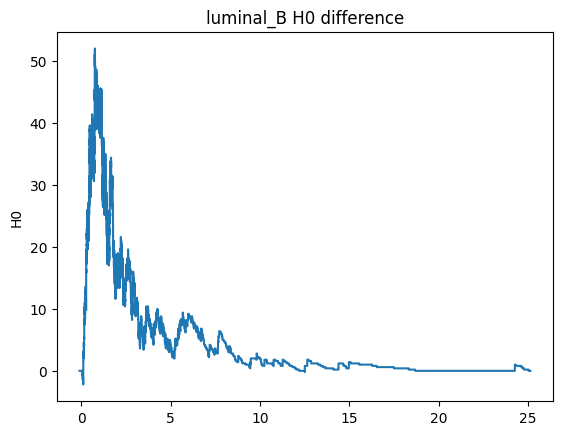

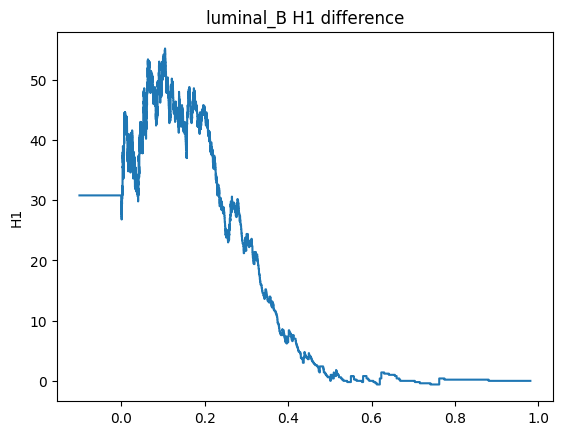

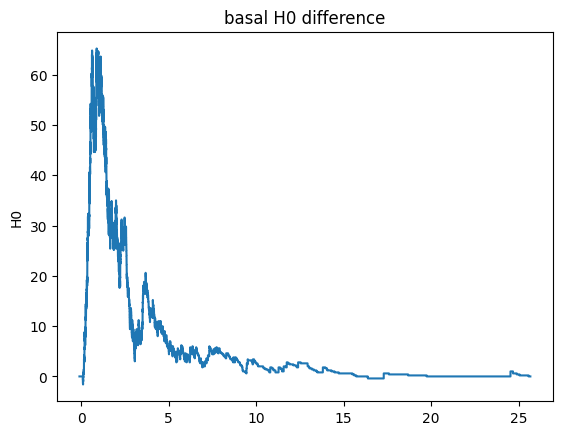

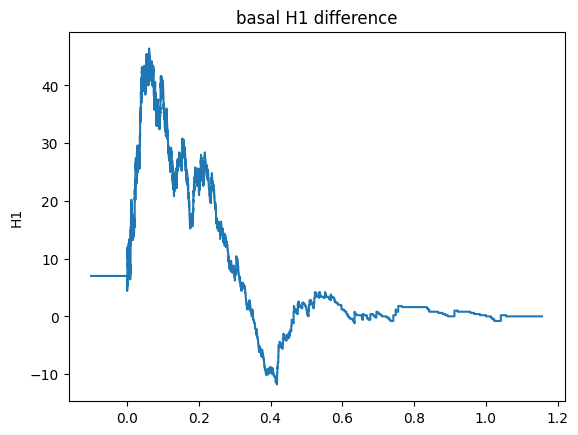

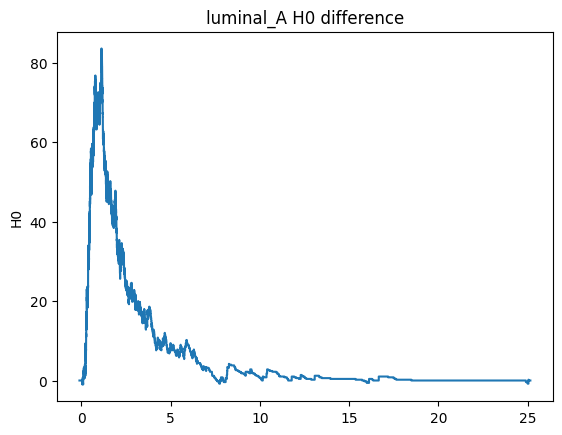

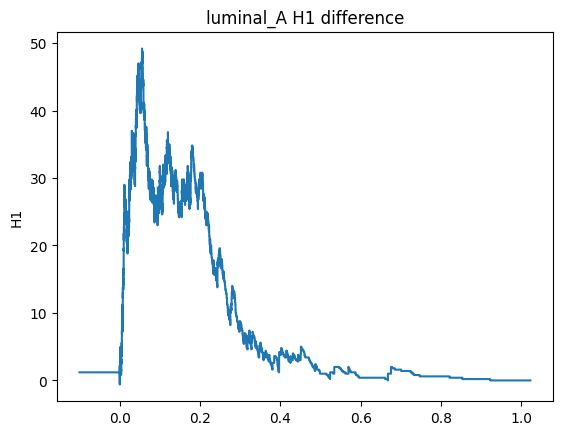

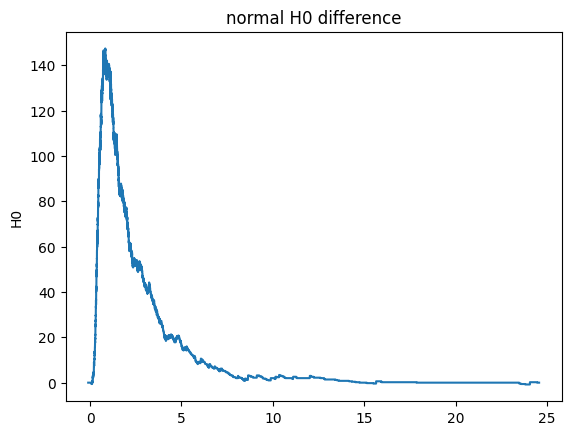

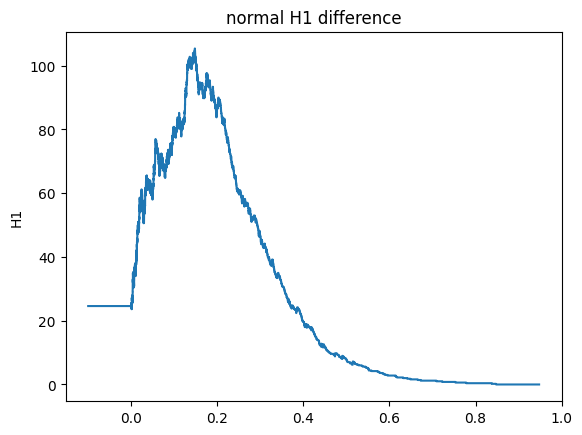

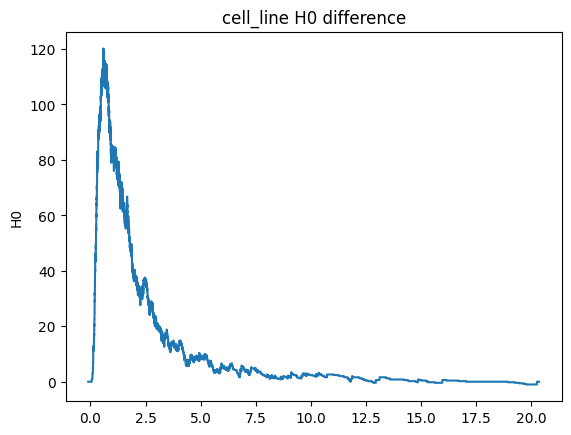

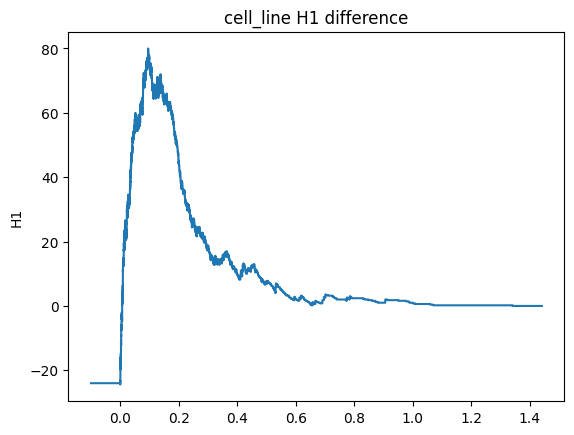

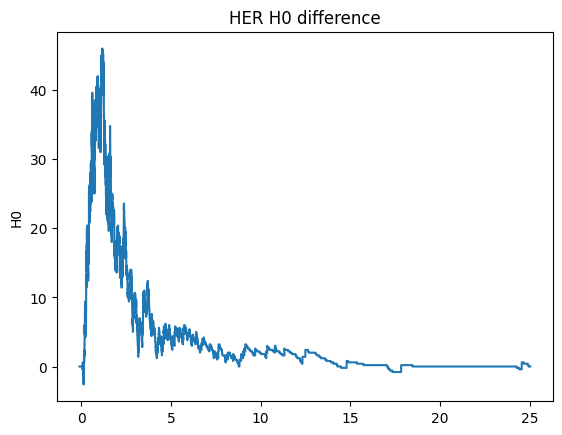

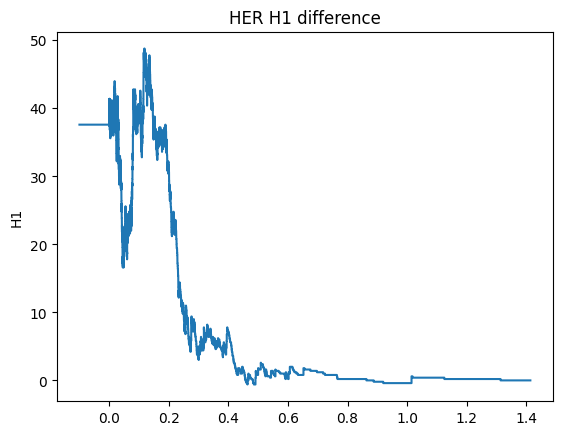

In [278]:
test_point = df_test.copy().sample(1)
#print(test_point)
test_label = np.array(test_point[['type']])[0]
md = 1
print('True type:',test_label)
Y = test_point.drop(columns = ['type'])
for cancer_type in types:
    df = df_train.loc[df_train['type'] == cancer_type]
    X = df.drop(columns=['type'])
    avg_hom, avg_dist = new_row_evaluation(X,Y, dist_type = 'euclidean', max_dim = md,max_size = 10000)
    
    for i in range(md+1):
        plt.figure()
        plt.title(cancer_type+" H" +str(i)+" difference")
        #avg_hom['H'+str(i)].plot(label = "Inserted data point")
        #train_data[cancer_type]['H'+str(i)].plot(label = "Train data")
        (avg_hom['H'+str(i)] - train_data[cancer_type]['H'+str(i)]).plot()
        plt.ylabel('H'+str(i))
        #plt.legend()
        
    print(cancer_type,avg_dist)

    